# Multiple Linear Regression

In [1]:
# importing the libraries:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt

Multiple linear regression generalizes linear regression, allowing the dependent variable to be a linear function of multiple independent variables. As before, we assume that the variable $Y$ is a linear function of $X_1,\ldots, X_k$:

$$ Y_i = \beta_0 + \beta_1 X_{1i} + \ldots + \beta_k X_{ki} + \epsilon_i $$
Often in finance the form will be written as follows, but it is just the variable name that changes and otherwise the model is identical.

$$ Y_i = \alpha + \beta_1 X_{1i} + \ldots + \beta_k X_{ki} + \epsilon_i $$
For observations $i = 1,2,\ldots, n$. In order to find the plane (or hyperplane) of best fit, we will use the method of ordinary least-squares (OLS), which seeks to minimize the squared error between predictions and observations, $\sum_{i=1}^n \epsilon_i^2$. The square makes positive and negative errors equally bad, and magnifies large errors. It also makes the closed form math behind linear regression nice, but we won't go into that now. For an example of squared error, see the following.

Let's say Y is our actual data, and Y_hat is the predictions made by linear regression.

In [7]:
Y = np.array([1, 3.5, 4, 8, 12])
Y_hat = np.array([1, 3, 5, 7, 9])
print(f'Error: {Y_hat-Y}')

# Squared Error:
SE = (Y_hat-Y)**2

print(f"Squared Error: {SE}")
print(f"Sum Squared Error: {np.sum(SE)}")

Error: [ 0.  -0.5  1.  -1.  -3. ]
Squared Error: [0.   0.25 1.   1.   9.  ]
Sum Squared Error: 11.25


Once we have used this method to determine the coefficients of the regression, we will be able to use new observed values of $X$ to predict values of $Y$.

Each coefficient $\beta_j$ tells us how much $Y_i$ will change if we change $X_j$ by one while holding all of the other dependent variables constant. This lets us separate out the contributions of different effects. This is assuming the linear model is the correct one.

We start by artificially constructing a $Y$, $X_1$, and $X_2$ in which we know the precise relationship.

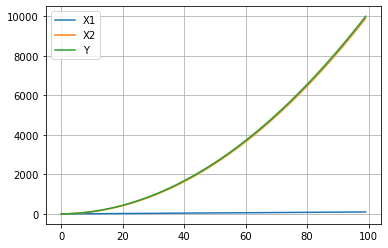

In [24]:
# Construct a simple linear curve of 1, 2, 3, ...
X1 = np.arange(100)

# Make a parabola and add X1 to it, this is X2
X2 = np.array([i ** 2 for i in range(100)]) + X1

# This is our real Y, constructed using a linear combination of X1 and X2
Y = X1 + X2

plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.plot(Y, label='Y')
plt.grid()
plt.legend();

In [25]:
# Use column_stack to combine independent variables, then add a column of ones so we can fit an intercept
X = sm.add_constant( np.column_stack((X1, X2) ))

# Run the model
results = regression.linear_model.OLS(Y, X).fit()

In [26]:
# So now, we have three parameters to be estimates, one for the constant, second for X1 i.e. beta1 and third for X2 i.e. beta2:
print(f"Alpha: {results.params[0]}")
print(f"Beta 1: {results.params[1]}")
print(f"Beta 2: {results.params[2]}")

Alpha: -1.5347723092418164e-12
Beta 1: 1.0000000000003801
Beta 2: 0.9999999999999957


Running a linear regression on two securities might give a high $\beta$. However, if we bring in a third security (like SPY, which tracks the S&P 500) as an independent variable, we may find that the correlation between the first two securities is almost entirely due to them both being correlated with the S&P 500. This is useful because the S&P 500 may then be a more reliable predictor of both securities than they were of each other. This method allows us to better gauge the significance between the two securities and prevent confounding the two variables.

In [28]:
# let us load the data:
import pandas_datareader.data as web
import datetime as dt

start = dt.datetime(2014,1,1)
end = dt.datetime(2015,1,1)

asset1 =  web.DataReader('TSLA', "yahoo", start, end)['Adj Close']
asset2 =  web.DataReader('FISV', "yahoo", start, end)['Adj Close']
benchmark =  web.DataReader('SPY', "yahoo", start, end)['Adj Close']

 Now, we run a linear regression on just the two assets i.e. $ Y = \alpha + \beta X $ where Y = asset1 (TSLA) and X is asset2 (FISV).
 In short, we have: $$ (TSLA) = \alpha + \beta (FISV )$$

In [31]:
slr_2 = regression.linear_model.OLS(asset1, sm.add_constant(asset2)).fit()
print(f"Alpha of only two assets regression: {slr_2.params[0]}")
print(f"Beta of only two assets regression: {slr_2.params[1]}")

Alpha of only two assets regresion: 8.066137961634276
Beta of only two assets regresion: 1.1785378319481201


Now, we run a linear regression on three of them i.e. $ Y = \alpha + \beta_{1} X_{1} + \beta_{2} X_{2}$ where $Y$ = asset1 (TSLA) and $X_{1}$ is asset2 (FISV) and $X_{2}$ is benchmark i.e. SPY
In short, we have: $$ (TSLA) = \alpha + \beta_{1} (FISV) + \beta_{2} (SPY)$$

In [33]:
X = np.column_stack((asset2, benchmark))
slr_3 = regression.linear_model.OLS(asset1, sm.add_constant(X)).fit()
print(f"Alpha of three assets regression: {slr_3.params[0]}")
print(f"Beta 1 (with FISV) of three assets regression: {slr_3.params[1]}")
print(f"Beta 2 (with SPY) of three assets regression: {slr_3.params[2]}")

Alpha of three assets regression: -56.696614491583944
Beta 1 (with FISV) of three assets regression: -1.4630855467745678
Beta 2 (with SPY) of three assets regression: 0.8668699297728901


In [44]:
# Now let us see the predictions. We will predict using the 3-assets regression i.e. Multiple Linear Regression:
prediction_3 = slr_3.params[0] + slr_3.params[1]*asset2 + slr_3.params[2]*benchmark
prediction_3.name = "Prediction 3"

In [45]:
# Now let us see the predictions using only two assets (Case 1):
prediction_2 = slr_2.params[0] + slr_2.params[1]*asset2
prediction_2.name = "Prediction 2"

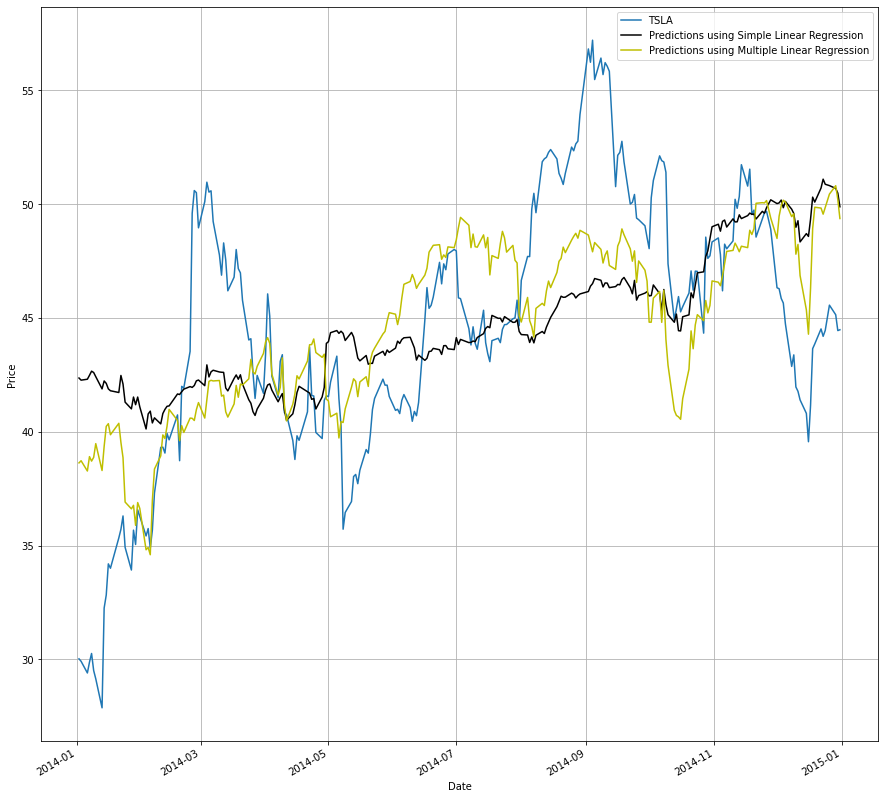

In [50]:
# Let us first increase the size of the plot
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

# Now let us plot them all:
asset1.plot(label="TSLA")
# asset2.plot(label="FSIV")
# benchmark.plot(label="S&P 500")
prediction_2.plot(color="black", label="Predictions using Simple Linear Regression")
prediction_3.plot(color="y", label="Predictions using Multiple Linear Regression")
plt.ylabel("Price")
plt.legend()
plt.grid();

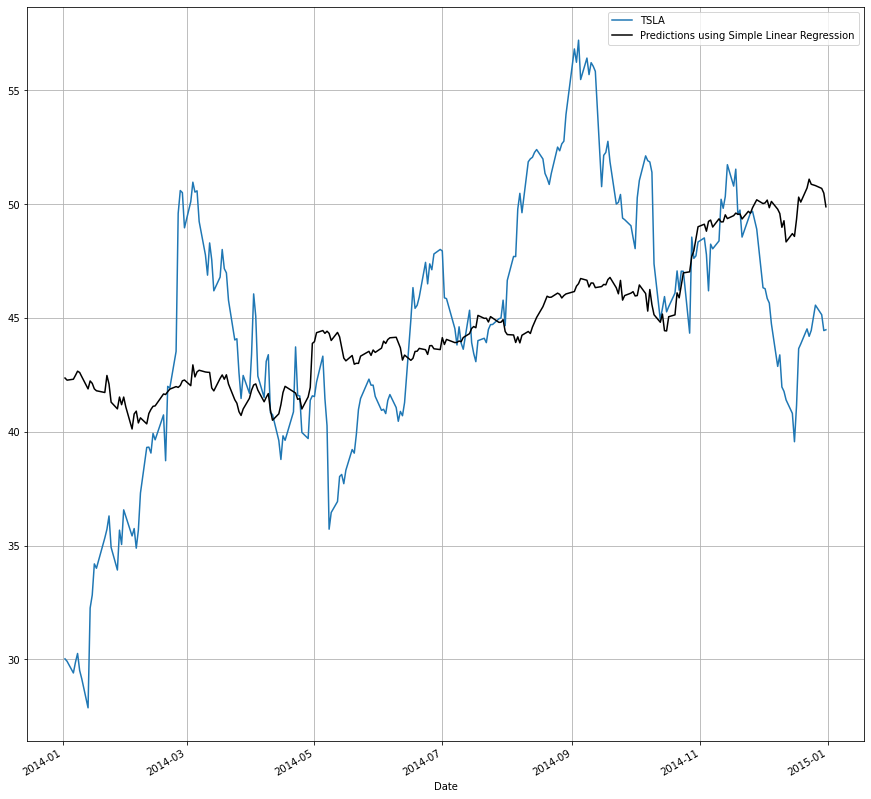

In [51]:
# Let us see how Simple Linear Regression compared with the actual results:
asset1.plot(label="TSLA")
prediction_2.plot(color="black", label="Predictions using Simple Linear Regression")
plt.grid()
plt.legend()
plt.show();

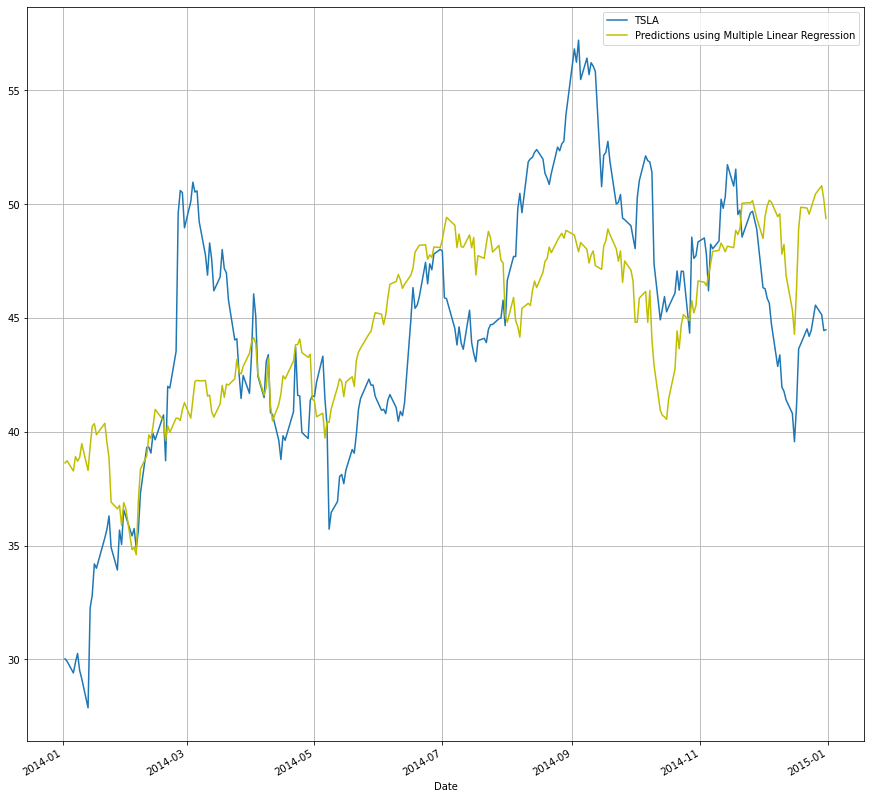

In [54]:
# Let us see how Multiple Linear Regression compared with the actual results:
asset1.plot(label="TSLA")
prediction_3.plot(color="y", label="Predictions using Multiple Linear Regression")
plt.grid()
plt.legend()
plt.show();

In [55]:
# Let us get some statistics of the fit of Simple Linear Regression:
slr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     75.89
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           4.19e-16
Time:                        16:01:36   Log-Likelihood:                -769.23
No. Observations:                 252   AIC:                             1542.
Df Residuals:                     250   BIC:                             1550.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0661      4.214      1.914      0.057      -0.233      16.365
Adj Close      1.1785      0.135      8.711      0.000       0.912       1.445
==============================================================================
Omnibus:                        3.286   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.193   Jarque-Bera (JB):                3.344
Skew:                          -0.273   Prob(JB):                        0.188
Kurtosis:                       2.856   Cond. No.                         406.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# Let us get some statistics of the fit of Multiple Linear Regression:
slr_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     86.70
Date:                Wed, 02 Jun 2021   Prob (F-statistic):           2.66e-29
Time:                        16:01:55   Log-Likelihood:                -736.04
No. Observations:                 252   AIC:                             1478.
Df Residuals:                     249   BIC:                             1489.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -56.6966      8.342     -6.796      0.000     -73.127     -40.266
x1            -1.4631      0.327     -4.470      0.000      -2.108      -0.818
x2             0.8669      0.100      8.662      0.000       0.670       1.064
==============================================================================
Omnibus:                        9.561   Durbin-Watson:                   0.071
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                5.343
Skew:                           0.157   Prob(JB):                       0.0691
Kurtosis:                       2.359   Cond. No.                     5.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model Selection Example

When deciding on the best possible model of your dependent variables, there are several different methods to turn to. 
1. If you use too many explanatory variables, you run the risk of overfitting your model, 
2. but if you use too few you may end up with a terrible fit. 

One of the most prominent methods to decide on a best model is stepwise regression. Forward stepwise regression starts from an empty model and tests each individual variable, selecting the one that results in the best model quality, usually measured with AIC or BIC (lowest is best). It then adds the remaining variables one at a time, testing each subsequent combination of explanatory variables in a regression and calculating the AIC or BIC value at each step. At the end of the regression, the model with the best quality (according to the given measure) is selected and presented as a the final, best model. This does have limitations, however. It does not test every single possible combination of variables so it may miss the theoretical best model if a particular variable was written off earlier in performing the algorithm. As such, stepwise regression should be used in combination with your best judgment regarding the model.

Let us create 4 independent variables $x_{1}, x_{2}, x_{3}$ and $x_{4}$ such that:
1. $x_{1} = x_{1}$
2. $x_{2} = x_{1}^{2} - x_{1}$
3. $x_{3} = ln(RandomNumber) + x_{2}$
4. $x_{4} = 5*x_{1} $

And we take the equation of regression as:
$$
y = 2x_{1} + 0.5x_{2} + 10x_{3} + x_{4}
$$

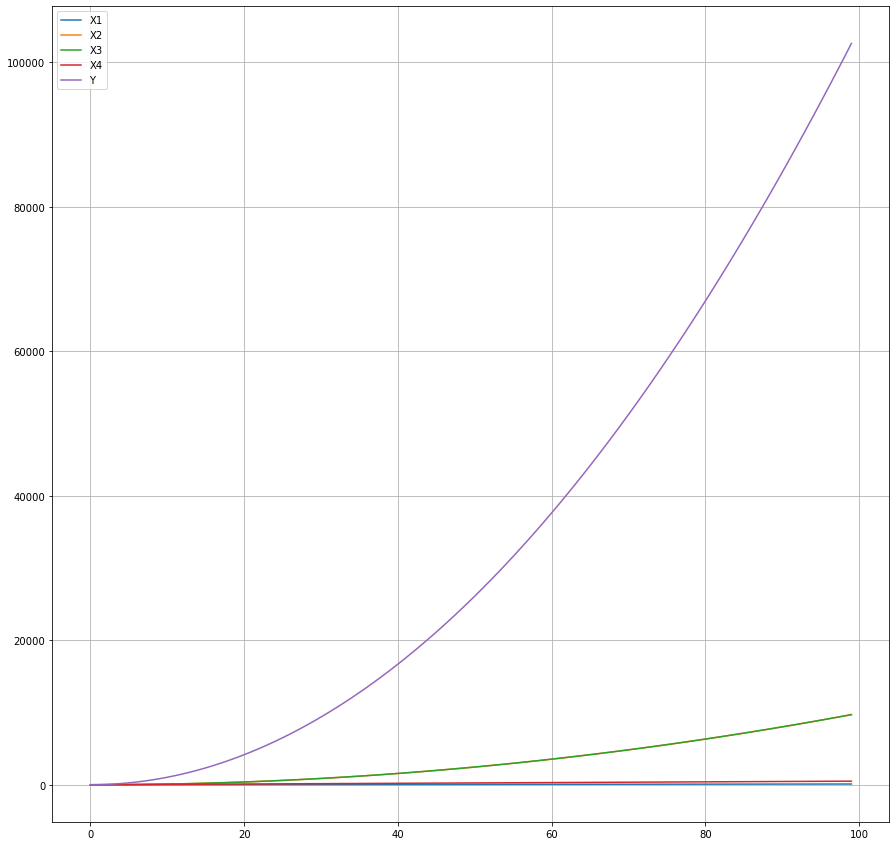

In [58]:
X1 = np.arange(100)
X2 = [i**2 for i in range(100)] - X1
X3 = [np.log(i) for i in range(1, 101)] + X2
X4 = 5 * X1
Y = 2 * X1 + 0.5 * X2 + 10 * X3 + X4

plt.plot(X1, label='X1')
plt.plot(X2, label='X2')
plt.plot(X3, label='X3')
plt.plot(X4, label='X4')
plt.plot(Y, label='Y')
plt.legend()
plt.grid();

Now, let us suppose we do not know the coefficients of $x_{1}, x_{2}, x_{3}$ and $x_{4}$ in the regression equation of $y$. Let us estimate the coefficients using multiple linear regression.

In [62]:
# We perform the regression:
X = np.column_stack((X1, X2, X3, X4))
results = regression.linear_model.OLS(Y, sm.add_constant(X)).fit()

In [63]:
# Let us print the results:
print(f"Alpha: {results.params[0]}")
print(f"Beta 1: {results.params[1]}")
print(f"Beta 2: {results.params[2]}")
print(f"Beta 3: {results.params[3]}")
print(f"Beta 4: {results.params[4]}")

Alpha: 8.640199666842818e-12
Beta 1: 0.2692307692307008
Beta 2: 0.5000000000045475
Beta 3: 9.999999999995907
Beta 4: 1.3461538461539106


In [64]:
predicted_vals = results.params[0] + results.params[1]*X1 + results.params[2]*X2 + results.params[3]*X3 + results.params[4]*X4

In [85]:
# Let us put the data in a dataframe:
data = pd.DataFrame(np.column_stack((X1,X2,X3,X4)), columns = ['X1','X2','X3','X4'])
response = pd.Series(Y, name='Y')